In [50]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import hopsy
import x3cflux
x3cflux.logging.level = 0
import pandas as pd

# Multi-Level Delayed Acceptance

## Setup

First, load the data from FluxML. The corresponding labeling model has 60 DOF.

In [51]:
simulator_hf = x3cflux.create_simulator_from_fml("spiralus.fml","ms_INST")
simulator_hf.parameter_space.num_free_parameters

4

Preconfigured relative/absolute tolerance for the forward simulation and the gradient are $10^{-6}$/$10^{-9}$.

In [52]:
simulator_hf.builder.solver.relative_tolerance, simulator_hf.builder.derivative_solver.relative_tolerance

(1e-06, 1e-06)

Now, create a mid fidelity simulator which only uses $10^{-3}$/$10^{-6}$ for simulation and gradient.

In [53]:
simulator_mf = x3cflux.create_simulator_from_fml("spiralus.fml", "ms_INST")
simulator_mf.builder.solver.relative_tolerance = 1e-3
simulator_mf.builder.solver.absolute_tolerance = 1e-4
simulator_mf.builder.derivative_solver.relative_tolerance = 1e-3
simulator_mf.builder.derivative_solver.absolute_tolerance = 1e-4

same for a low fidelity simulator 

In [54]:
simulator_lf = x3cflux.create_simulator_from_fml("spiralus.fml", "ms_INST")
simulator_lf.builder.solver.relative_tolerance = 1e-1
simulator_lf.builder.solver.absolute_tolerance = 1e-2
simulator_lf.builder.derivative_solver.relative_tolerance = 1e-1
simulator_lf.builder.derivative_solver.absolute_tolerance = 1e-2

Get an inital point in the polytope and check how the simulation speeds differ.

In [55]:
ineq_sys = simulator_hf.parameter_space.inequality_system
initial_point = x3cflux.get_parameters(simulator_hf.parameter_space, simulator_hf.configurations[0].parameter_entries) #starting_point

In [8]:
%timeit simulator_hf.compute_loss(initial_point)

3.09 ms ± 185 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit simulator_mf.compute_loss(initial_point)

897 μs ± 68.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
%timeit simulator_lf.compute_loss(initial_point)

399 μs ± 18.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Define the Multi-Level Delayed Acceptance proposal

In [56]:
class DelayedAcceptanceProposal:
    def __init__(self, problem: hopsy.Problem, problem_lf: hopsy.Problem, proposal_object,length: int = 10):
        self.problem = problem
        self.state = self.proposal = problem.starting_point
        self.state_log_density = problem.model.log_density(self.state)
        self.proposal_log_density = self.state_log_density
    
        init_chain_lf = hopsy.MarkovChain(problem_lf,starting_point=self.state)
        init_chain_lf.proposal=proposal_object
        self.chain_lf = init_chain_lf
        #print(self.chain_lf)
        self.length: int = length
        self.state_log_density_lf = self.chain_lf.state_log_density

    def propose(self, rng: hopsy.RandomNumberGenerator) -> np.ndarray:
        self.chain_lf.state = self.state
        for i in range(self.length):
            self.chain_lf.draw(rng)
        self.proposal = self.chain_lf.state
        self.proposal_log_density = self.problem.model.log_density(self.proposal)
        return self.proposal
    
    def accept_proposal(self) -> np.ndarray:
        self.state = self.proposal
        self.state_log_density = self.proposal_log_density
        self.state_log_density_lf = self.chain_lf.state_log_density
        return self.state

    def log_acceptance_probability(self) -> float:
        return self.proposal_log_density - self.state_log_density + \
            self.state_log_density_lf - self.chain_lf.state_log_density

In [57]:
def configure_mlda(models : hopsy.Problem, chain_lengths: int, mh_proposal: hopsy.Proposal):
    
    levels = len(models)
    
    da_proposals = [mh_proposal]     
    
    for l in range(1,levels):
        da_proposals.append(DelayedAcceptanceProposal(models[l],models[l-1],proposal_object=da_proposals[l-1],length = chain_lengths[l-1]))
    return da_proposals[levels-1]

## Sample models

In [58]:
n_samples = 10000
n_burnin = 0

In [59]:
problem_0 = hopsy.Problem(ineq_sys.matrix, ineq_sys.bound, x3cflux.HopsyModel(simulator_lf))
problem_0.starting_point = initial_point

problem_1 = hopsy.Problem(ineq_sys.matrix, ineq_sys.bound, x3cflux.HopsyModel(simulator_mf))
problem_1.starting_point = initial_point

problem_2 = hopsy.Problem(ineq_sys.matrix, ineq_sys.bound, x3cflux.HopsyModel(simulator_hf)) 
problem_2.starting_point = initial_point
"""
MLDA_01 = DelayedAcceptanceProposal(problem_1,problem_0, proposal_object=hopsy.GaussianHitAndRunProposal(problem_0), length = 3)
MLDA_12 = DelayedAcceptanceProposal(problem_2,problem_1, proposal_object=MLDA_01,length = 2)
chain = hopsy.MarkovChain(problem_2)
chain.proposal = MLDA_12 """

""" set-up mlda proposals and markov-chains """

mlda_proposals = [configure_mlda(models=[problem_0,problem_1,problem_2],chain_lengths=[2,3],mh_proposal=hopsy.CSmMALAProposal(problem_0)) for i in range(4)]
mlda_rngs = [hopsy.RandomNumberGenerator(seed = 42 + 42*i) for i in range(4)]

print(mlda_proposals)

mlda_chains = [hopsy.MarkovChain(problem=problem_2,starting_point=initial_point) for i in range(4)]

for i in range(4):
    mlda_chains[i].proposal = mlda_proposals[i] 
    

[<__main__.DelayedAcceptanceProposal object at 0x7f448824bc50>, <__main__.DelayedAcceptanceProposal object at 0x7f448849c770>, <__main__.DelayedAcceptanceProposal object at 0x7f44b974cb90>, <__main__.DelayedAcceptanceProposal object at 0x7f4488fd1370>]


In [ ]:
"""sample MLDA-MCMC""" 

mlda_meta, mlda_samples = hopsy.sample(mlda_chains, mlda_rngs, n_samples, record_meta=["acceptance_rate", "state_log_density"], progress_bar=True)

np.save("mlda_samples.csv",mlda_samples)

np.save("mlda_meta.npy",mlda_meta)


{'acceptance_rate': array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.]], shape=(4, 10000)), 'state_log_density': array([[-3.67078718e-01, -3.67078718e-01, -8.58341174e-01, ...,
        -7.93588215e-02, -7.93588215e-02, -7.93588215e-02],
       [-5.73958466e-01, -2.20664150e+00, -1.90985085e+00, ...,
        -1.15021901e+00, -1.15021901e+00, -1.15021901e+00],
       [-5.81457488e-05, -1.18578330e-01, -3.18309103e-01, ...,
        -7.44042912e-01, -7.44042912e-01, -9.34460118e-01],
       [-5.81457488e-05, -5.81457488e-05, -5.81457488e-05, ...,
        -1.21935150e+00, -1.21935150e+00, -1.21935150e+00]],
      shape=(4, 10000))}


In [60]:

mlda_meta = np.load("mlda_meta.npy", allow_pickle=True)
mlda_samples = np.load("mlda_samples.npy")

print("r_hats", hopsy.rhat(mlda_samples[:,n_burnin:,:]))
print("mlda_ess",((hopsy.ess(mlda_samples[:,n_burnin:,:]))))
print("mlda_acceptance_rate",mlda_meta.item().get("acceptance_rate").mean(axis=1))



r_hats [[1.00252636 1.0016346  1.01135911 1.00214424]]
mlda_ess [[1917.04761874 2168.04213426  241.57062295 1489.30763468]]
mlda_acceptance_rate [0.8803 0.8734 0.8805 0.8794]


In [61]:
test_chains = [hopsy.MarkovChain(problem_2,proposal=hopsy.CSmMALAProposal, starting_point = initial_point) for i in range(4)]
test_rngs = [hopsy.RandomNumberGenerator(seed = (i+5)*42) for i in range(4)]

for mc in test_chains:
    mc.proposal.stepsize = 0.5
    mc.proposal.fisher_weight = 0.9

tuning_target = "esjd" 
hopsy.tune(test_chains, test_rngs, target=tuning_target, n_tuning=5000)


({'CSmMALAProposal': [<hopsy.core.MarkovChain at 0x7f4494b48ef0>,
   <hopsy.core.MarkovChain at 0x7f448826b1f0>]},
 {'CSmMALAProposal': [hopsy.RandomNumberGenerator(seed=210),
   hopsy.RandomNumberGenerator(seed=252),
   hopsy.RandomNumberGenerator(seed=294),
   hopsy.RandomNumberGenerator(seed=336)]},
 ({'CSmMALAProposal': GaussianProcessRegressor(alpha=array([0.20053201, 0.70204556, 0.51853303, 0.72634165, 0.77242824,
          0.26958982, 0.37336423, 0.35454602, 0.27537641, 0.63181101,
          1.27235357, 0.83609304, 0.48852557, 0.39195176, 0.13449535,
          0.23484185, 0.18442831, 0.14021808, 0.48986341, 0.4364908 ,
          0.27007825, 0.36513702, 0.67789045, 0.57111768, 0.40331749,
          0.30830346, 0.51149107, 0.95728118, 0.793...
          0.37750243, 1.31454799, 2.37689124, 1.56601552, 0.8998463 ,
          0.37580801, 1.27722448, 1.35823885, 0.66906444, 0.38252402,
          0.59286336, 1.05575773, 0.28111451, 0.85649449, 1.84789072,
          1.11411186, 0.4147227

In [ ]:
test_meta, test_samples = hopsy.sample(test_chains,test_rngs,n_samples=n_samples,record_meta=["acceptance_rate", "state_log_density"],progress_bar=True)

#np.save("test_samples.npy",test_samples)
#np.save("test_meta.npy",test_meta)

#total computation-time: 34 minutes for 4 chains, so 8.5 min per one chain. 
#average ESS/S is 472 / 8.5*60 = 1 Effective Samples / second 

#mysteriously: hopsy tune causes ESS of 1. 

chain 0:   0%|          | 0/10000 [00:00<?, ?it/s]

chain 3: 100%|██████████| 10000/10000 [05:12<00:00, 32.05it/s]


In [48]:
test_samples = np.load("test_samples.npy")
test_meta = np.load("test_meta.npy", allow_pickle=True)

print("r_hats", hopsy.rhat(test_samples[:,n_burnin:,:]))
print("test_ess",(hopsy.ess(test_samples[:,n_burnin:,:])))
print("test_acceptance_rate",test_meta.item().get("acceptance_rate").mean(axis=1))

r_hats [[1.00161213 1.00394421 1.00855372 1.00341326]]
test_ess [[1822.2674742  1482.05101902  484.25373364 1374.18405971]]
test_acceptance_rate [0.4647 0.4553 0.4617 0.466 ]


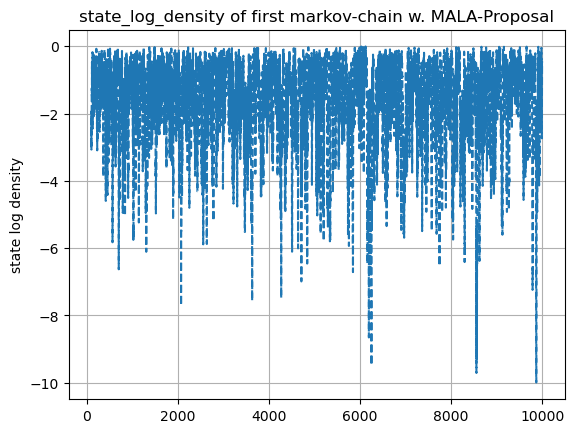

In [47]:
#plt.plot(range(0, n_samples), meta["state_log_density"][:, n_burnin:].T, ls="-")
plt.figure()
plt.title("state_log_density of first markov-chain w. MALA-Proposal")
plt.xlabel("state-trajectory")
plt.ylabel("state log density")
plt.xlabel("")
plt.plot(range(n_burnin,n_samples), test_meta.item().get("state_log_density")[0,n_burnin:].T, ls = "--")
plt.grid()

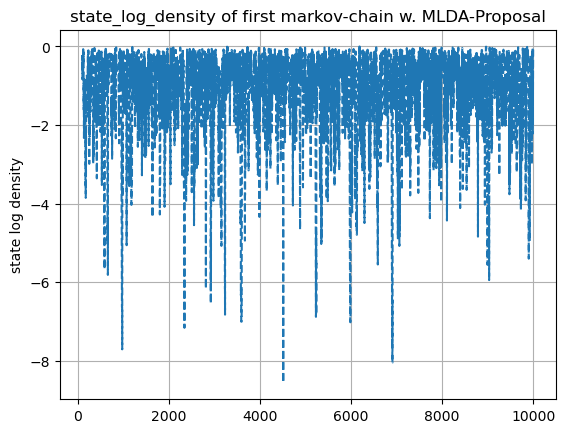

In [45]:
#plt.plot(range(0, n_samples), meta["state_log_density"][:, n_burnin:].T, ls="-")
plt.figure()
plt.title("state_log_density of first markov-chain w. MLDA-Proposal")
plt.xlabel("state-trajectory")
plt.ylabel("state log density")
plt.xlabel("")
plt.plot(range(n_burnin,n_samples), mlda_meta.item().get("state_log_density")[0,n_burnin:].T, ls = "--")
plt.grid()